In [1]:
from PIL import Image,ImageFilter
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
import scipy
from scipy.signal import wiener
from skimage import color,data,restoration
from scipy.signal import convolve2d
from __future__ import division
import scipy.stats as stats

%matplotlib inline

In [2]:
def ListofFiles(path):
    filelist=[]
    for root, dirs, files in os.walk(path):
        for file in files:
             filelist.append(os.path.join(root,file))
    return filelist

def getImageValues(Files,EventLimit=1,size=(512,512)):
    if(type(Files) is list):
        values={}
        count=0
        for file in Files:
            img1=Image.open(file)
            if(size[0]!=img1.size[0] and size[1]!=img1.size[1]):
                img1=img1.resize(size)
            imgArray=np.array(img1)
            values[count]=imgArray
            count+=1
            if(EventLimit==count):
                break
        print(f" {count} frames in dictinary ")
    else:
        img1=Image.open(Files)
        values=np.array(img1)
    return values

def getPowerSpectrum(imgs,backgrounds,Name):
    # take dft
    
    TotalNoisePS=0
    TotalDataPS=0
    imgdata=0
    bgdata=0
    DataCount=0
    BgnCount=0
    Signalhist=np.array([])
    Noisehist=np.array([])
    Filename=Name+".p"
    Values={}
    
    if(not(os.path.exists(Filename))): 
        for background in backgrounds:
            bgndfft=np.fft.fft2(backgrounds[background])
            bgspecnoise=(np.abs(bgndfft))**2
            TotalNoisePS+=bgspecnoise
            bgdata+=backgrounds[background]
            BgnCount+=1
            #Noisehist=np.append(Noisehist,np.ndarray.flatten(bgspecnoise))

        for  data in imgs :
            datadft = np.fft.fft2(imgs[data])
            signalps=(np.abs(datadft))**2
            TotalDataPS += signalps
            imgdata+=imgs[data]
            DataCount+=1
            #Signalhist=np.append(Signalhist,np.ndarray.flatten(signalps))
        
        AvgNoiseSpec=TotalNoisePS/BgnCount
        AvgDataSpec=TotalDataPS/DataCount
        wiener1 = (AvgDataSpec-AvgNoiseSpec)/(AvgDataSpec)
        imgdataAvg=(imgdata/DataCount)
        BgndataAvg=(bgdata/BgnCount)
        Values["imgs"]=imgdataAvg
        Values["bgns"]=BgndataAvg
        Values["PSData"]=AvgDataSpec
        Values["PSBg"]=AvgNoiseSpec
        Values["Wiener2D"]=wiener1
        PickleITDump(Values,Filename)

    else:
        Values=PickleITRead(Filename)
        wiener1=Values["Wiener2D"]
        AvgDataSpec=Values["PSData"]
        AvgNoiseSpec=Values["PSBg"]
        imgdataAvg=Values["imgs"]
        BgndataAvg=Values["bgns"]
    print(f"Img Dimension --> {AvgNoiseSpec.shape[0]}x{AvgNoiseSpec.shape[1]}" )

    
    # clip and convert to uint8
    #restored = restored.clip(0,255).astype(np.uint8)

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(30, 20), sharex=True, sharey=True)
    ax[0].set_title('All Images')
    ax[0].imshow(imgdataAvg,cmap='gray',origin="lower")
    ax[1].set_title('All Background')
    ax[1].imshow(BgndataAvg,cmap='gray',origin="lower")

   
    return wiener1,AvgNoiseSpec,AvgDataSpec,BgndataAvg,imgdataAvg

def PpectrumNormed(img,bgn,Title,file):
    if(file):
        Values=PickleITRead(file)
        img=Values["PSData"]
        bgn=Values["PSBg"]
        
    npix=img.shape[0]

    ## Obtain the freq
    kfreq=np.fft.fftfreq(npix)*npix

    ## Create a meshgrid
    kfreq2D=np.meshgrid(kfreq,kfreq)
    ## Normalize it
    knrm=np.sqrt(kfreq2D[0]**2+kfreq2D[1]**2)

    ## Convert it to 1d array
    knrm=knrm.flatten()
    Fourier_Amplitudes_img1=img.flatten()
    Fourier_Amplitudes_background=bgn.flatten()
    #print(len(Fourier_Amplitudes_img1))
    ### binning 
    
    kbins = np.arange(0.5, npix//2+1, 1.)
    #kbins = np.arange(1, npix, 1.)

    kvals = 0.5 * (kbins[1:] + kbins[:-1])
    Abins, _, _ = stats.binned_statistic(knrm, Fourier_Amplitudes_img1,
                                         statistic = "mean",
                                         bins = kbins)
    AbinsBackground, _, _ = stats.binned_statistic(knrm, Fourier_Amplitudes_background,
                                         statistic = "mean",
                                         bins = kbins)
    
    Abins *= np.pi * (kbins[1:]**2 - kbins[:-1]**2)
 
    
    AbinsBackground *= np.pi * (kbins[1:]**2 - kbins[:-1]**2)
   

    ImgY=Abins/kvals
    BgY=AbinsBackground/kvals
    
    ### Mask it
    xlow=100
    xhigh=256
    Mask=np.where(np.logical_and(kvals>=xlow,kvals<=xhigh))


    
    IntegralBG=np.trapz(BgY[Mask],dx=1)
    IntegralSig=np.trapz(ImgY[Mask],dx=1)
    BgNormed=BgY*(IntegralSig/IntegralBG)
    
    weiner=(ImgY-BgNormed)/ImgY
    weinerNormed=(np.trapz(ImgY,dx=1)/np.trapz(weiner,dx=1))*weiner
    WeinerMask=kvals>=xlow
    
    #weinerNormed[WeinerMask]=0.5
    #weiner[WeinerMask]=0.5
    #weinerNormed[WeinerMask]=0
    #weiner[WeinerMask]=0
    
    
    #WeinerByForce=(ImgY-BgY)/ImgY
    #WeinerByForceNormed=(np.trapz(ImgY,dx=1)/np.trapz(WeinerByForce,dx=1))*WeinerByForce
    #WeinerByForceNormed[WeinerMask]=0
    print(f"Minimum kval = {min(kvals)} and Maximum kval= {max(kvals)}")
    plt.plot(kvals,ImgY,label="signal")
    plt.plot(kvals,BgNormed,label="BackgroundNormed")
    plt.plot(kvals,BgY,label="Background")
    plt.plot(kvals,weinerNormed,label="Weiner")

    #plt.plot(kvals,WeinerByForceNormed,label="Forced",color='y')
    plt.loglog()
    plt.axvline(xlow,color='r')
    plt.axvline(xhigh,color='r',label="IntegrationWindow")
    #print((Abins/kvals))
    #print(kvals)
    
    plt.title(Title)
    plt.xlabel("$k$")
    plt.ylabel("$P(k)$")
    plt.tight_layout()
    plt.ylim(1e5)
    plt.legend()
    plt.show()
    
    Values["Wiener1D"]=weiner
    PickleITDump(Values,file)
    return weiner
    #plt.savefig("img1_power_spectrum.png", dpi = 300, bbox_inches = "tight")    
def PickleITDump(data,fileName):
    with open(fileName,'wb') as f:
        pickle.dump(data,f)
        
def PickleITRead(fileName):
    
    with open(fileName,'rb') as f:
        data=pickle.load(f)
    return data

In [3]:
##### Day 1 ####
if(not(os.path.exists("NoELDay1_test.p"))): 
    NoEl=ListofFiles("/home/ilker/Desktop/Camera Tracks/07.22.22/10kVgap_Pb210/EL-NoEL/NoEl")
    BackGround=getImageValues(NoEl,EventLimit=-1,size=(1024,1024))
    PickleITDump(BackGround,"NoELDay1_test.p")
else:
    BackGround=PickleITRead("NoELDay1_test.p")
    
if(not(os.path.exists("ELDay1_test.p"))):
    Day1El=ListofFiles("/home/ilker/Desktop/Camera Tracks/07.22.22/10kVgap_Pb210/EL-NoEL/EL")
    ELDay1Images=getImageValues(Day1El,EventLimit=-1,size=(1024,1024))
    PickleITDump(ELDay1Images,"ELDay1_test.p")
else:
    ELDay1Images=PickleITRead("ELDay1_test.p")
    
#### Day 2 ###    
if(not(os.path.exists("NoELDay_test.p"))):
    NoELDay2=ListofFiles("/home/ilker/Desktop/Camera Tracks/07.23.22/0kV EL")
    BackGroundDay2=getImageValues(NoELDay2,EventLimit=-1,size=(1024,1024))
    PickleITDump(BackGroundDay2,"NoELDay_test.p")
else:
    BackGroundDay2=PickleITRead("NoELDay_test.p")
    
if(not(os.path.exists("ELDay2_test.p"))):
    Day2El=ListofFiles("/home/ilker/Desktop/Camera Tracks/07.23.22/10kV EL")
    ELDay2Images=getImageValues(Day2El,EventLimit=-1,size=(1024,1024))
    PickleITDump(ELDay2Images,"ELDay2_test.p")
else:
    ELDay2Images=PickleITRead("ELDay2_test.p")


Img Dimension --> 1024x1024


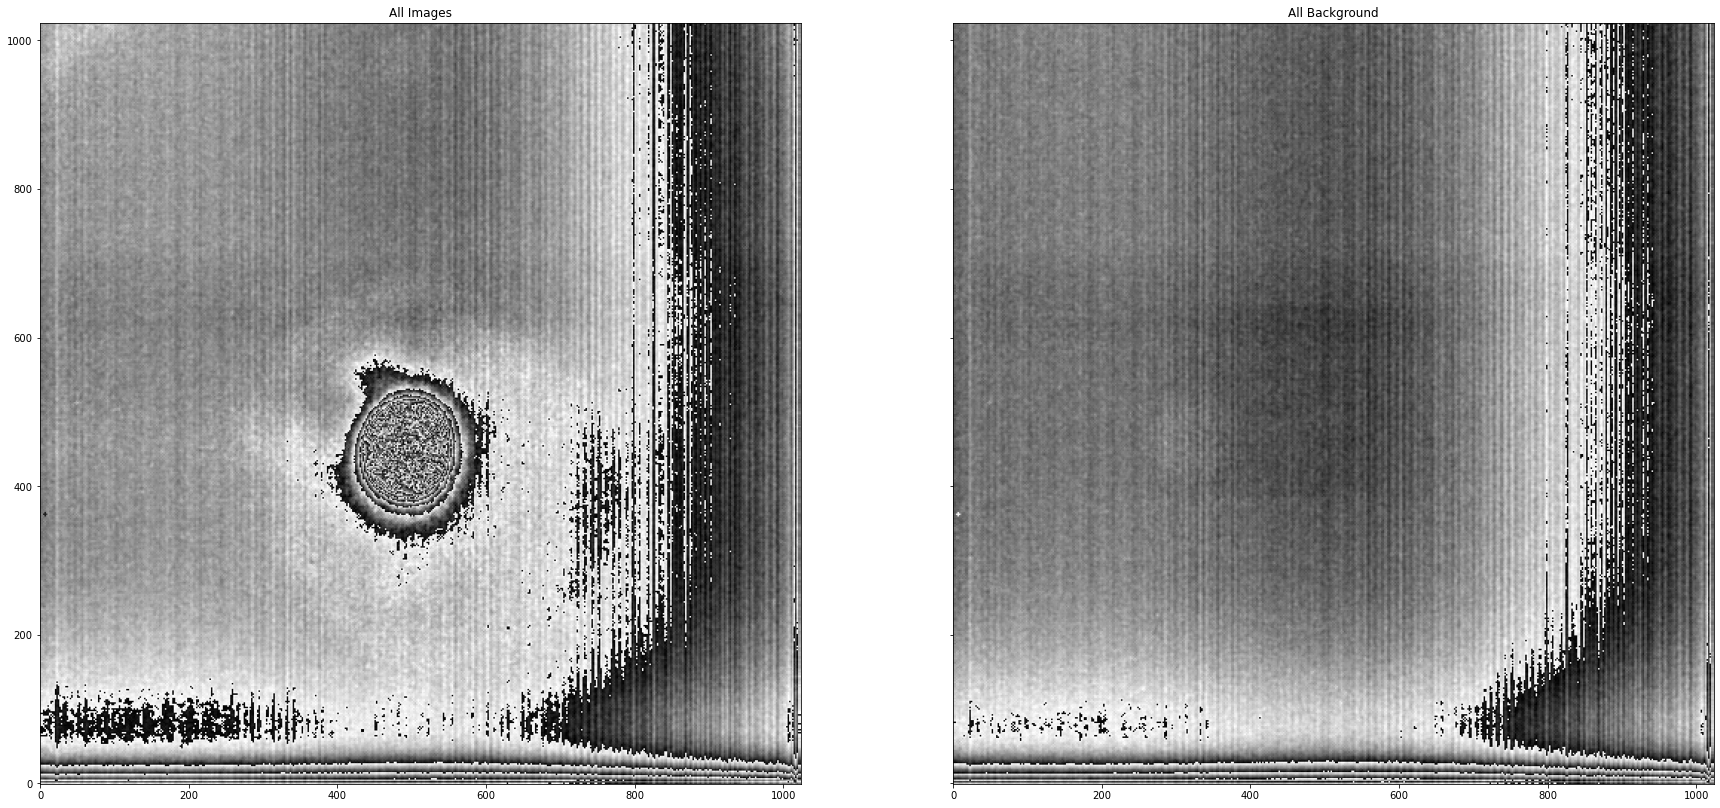

In [4]:
pws=getPowerSpectrum(ELDay1Images,BackGround,"WienerDay1_test")

Minimum kval = 1.0 and Maximum kval= 512.0


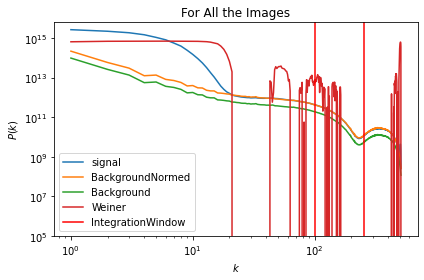

[ 9.18081302e-01  9.73640133e-01  9.83740244e-01  9.91519305e-01
  9.87543594e-01  9.90018603e-01  9.87186242e-01  9.85465991e-01
  9.84229656e-01  9.73376664e-01  9.66594408e-01  9.45824069e-01
  9.28207686e-01  8.80038507e-01  7.99624537e-01  7.26587627e-01
  5.55668831e-01  3.80185738e-01  2.13843791e-01  9.36140524e-02
  2.79108860e-02 -6.58437128e-02 -7.64887426e-02 -1.04607066e-01
 -9.34611115e-02 -1.06080300e-01 -1.23019472e-01 -9.79139428e-02
 -1.19674565e-01 -9.16821760e-02 -1.07488448e-01 -1.03117680e-01
 -1.22723633e-01 -6.64855278e-02 -6.30077162e-02 -4.95094763e-02
 -5.19178604e-02 -3.68728765e-02 -3.80622171e-02 -1.70054952e-02
 -1.00865220e-02 -8.07758329e-03  9.70392411e-03  8.26371498e-03
  8.11208344e-04  2.44917995e-03  3.59662445e-02  5.06636076e-02
  4.07318419e-02  4.79557561e-02  5.18217323e-02  5.09868461e-02
  5.46708768e-02  4.29393010e-02  4.10031952e-02  3.99932482e-02
  3.63009995e-02  3.08553212e-02  2.93240553e-02  2.06884337e-02
  9.68944921e-03  1.14051

In [5]:
Wiener1d=PpectrumNormed(pws[2],pws[1],"For All the Images","WienerDay1_test.p")
print(Wiener1d)

In [6]:
kk=np.meshgrid(Wiener1d,Wiener1d)
r=np.sqrt(kk[0]**2+kk[1]**2)

In [ ]:
pip install pickleshare

In [7]:

ELDay1ImagesTest=PickleITRead("ELDay1.p")
ELDay2ImagesTest=PickleITRead("ELDay2.p")


[[1.29836303 1.33822583 1.34559212 ... 1.19892941 1.05224765 0.91949956]
 [1.33822583 1.37693508 1.38409536 ... 1.24198775 1.1010572  0.97497757]
 [1.34559212 1.38409536 1.3912188  ... 1.24992133 1.10999852 0.98506397]
 ...
 [1.19892941 1.24198775 1.24992133 ... 1.09046638 0.92677414 0.77276427]
 [1.05224765 1.1010572  1.10999852 ... 0.92677414 0.72712013 0.51667979]
 [0.91949956 0.97497757 0.98506397 ... 0.77276427 0.51667979 0.07219641]]
18551.33968715034
19476.11658618029


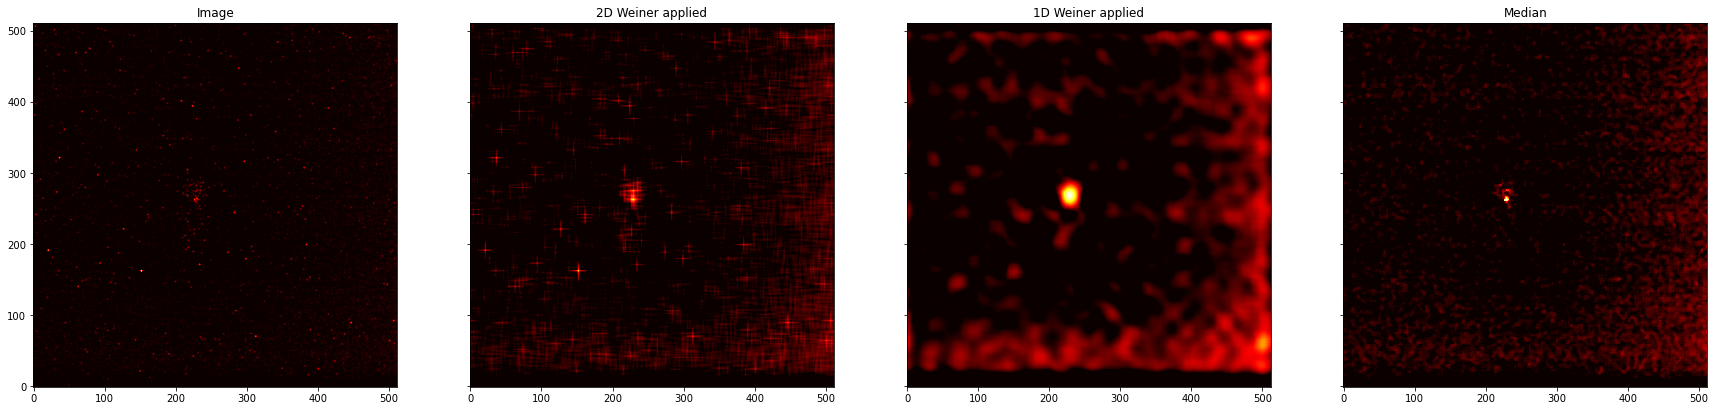

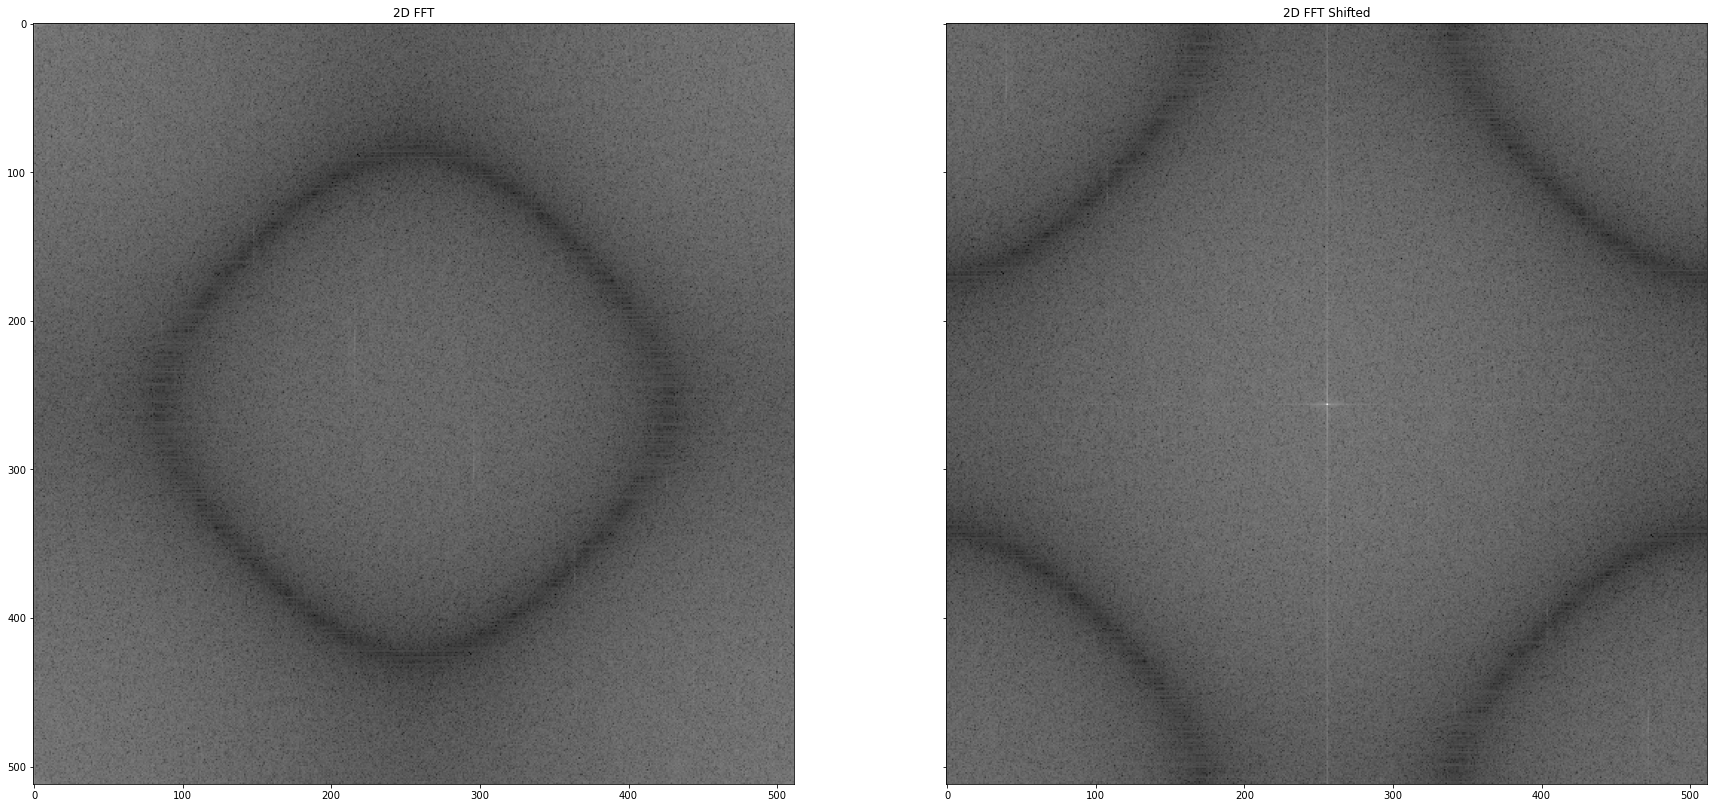

In [8]:

#### Single Image Recovery
SingleImg=ELDay1ImagesTest[13]
fft_SingleImg=np.fft.fft2(SingleImg)
PS_SingleImg=(np.abs(fft_SingleImg))**2

## 2D wiener
restored = np.fft.ifft2(fft_SingleImg*(kk[0]+kk[1]))
restored = np.real(restored)

print(r)
## 1D Wiener
test=scipy.ndimage.median_filter(SingleImg,size=6)

#unshifted=fft_SingleImg*kk[0]*kk[1]
unshifted=fft_SingleImg*kk[0]*kk[1]
restored2 = np.fft.ifft2(unshifted)

restored2 = np.real(restored2)

# take real() component (or do abs())

print(np.amin(restored))
print(np.amax(restored))
# clip and convert to uint8
#SingleImg=np.real(SingleImg).clip(0,255).astype(np.uint8)
#restored2 = restored2.clip(0,255).astype(np.uint8)
#restored = restored.clip(0,255).astype(np.uint8)
#restored3 = restored3.clip(0,255).astype(np.uint8)
#test = test.clip(0,255).astype(np.uint8)

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(30, 20), sharex=True, sharey=True)
ax[0].set_title('Image')
ax[0].imshow(SingleImg,cmap=plt.get_cmap('hot'),origin="lower",vmin=(np.mean(SingleImg)), vmax=np.max(SingleImg))
ax[1].set_title('2D Weiner applied')
ax[1].imshow(restored,cmap=plt.get_cmap('hot'),origin="lower",vmin=(np.mean(restored)), vmax=np.max(restored))
ax[2].set_title('1D Weiner applied')
ax[2].imshow(restored2,cmap=plt.get_cmap('hot'),origin="lower",vmin=(np.mean(restored2)), vmax=np.max(restored2))
ax[3].set_title('Median')
ax[3].imshow(test,cmap=plt.get_cmap('hot'),origin="lower", interpolation='nearest',vmin=(np.mean(test)), vmax=np.max(test))

#restore5 = restore5.clip(0,255).astype(np.uint8)

#ax[1].imshow(20*np.log10(abs(fft_SingleImg)*),cmap='gray')
plt.show()
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(30, 20), sharex=True, sharey=True)
ax[0].set_title('2D FFT')
ax[0].imshow(10*np.log10(np.abs(fft_SingleImg)),cmap='gray')
ax[1].set_title('2D FFT Shifted')
ax[1].imshow(10*np.log10(np.abs(np.fft.fftshift(fft_SingleImg))),cmap='gray')
#ax[1].set_title('2D Weiner applied')
#ax[1].imshow(10*np.log10(np.abs(np.fft.fft(restored))),cmap='gray')
#ax[2].set_title('1D Weiner applied')
#ax[2].imshow(10*np.log10(np.abs(np.fft.fft(restored2))),cmap='gray')




Img Dimension --> 1024x1024


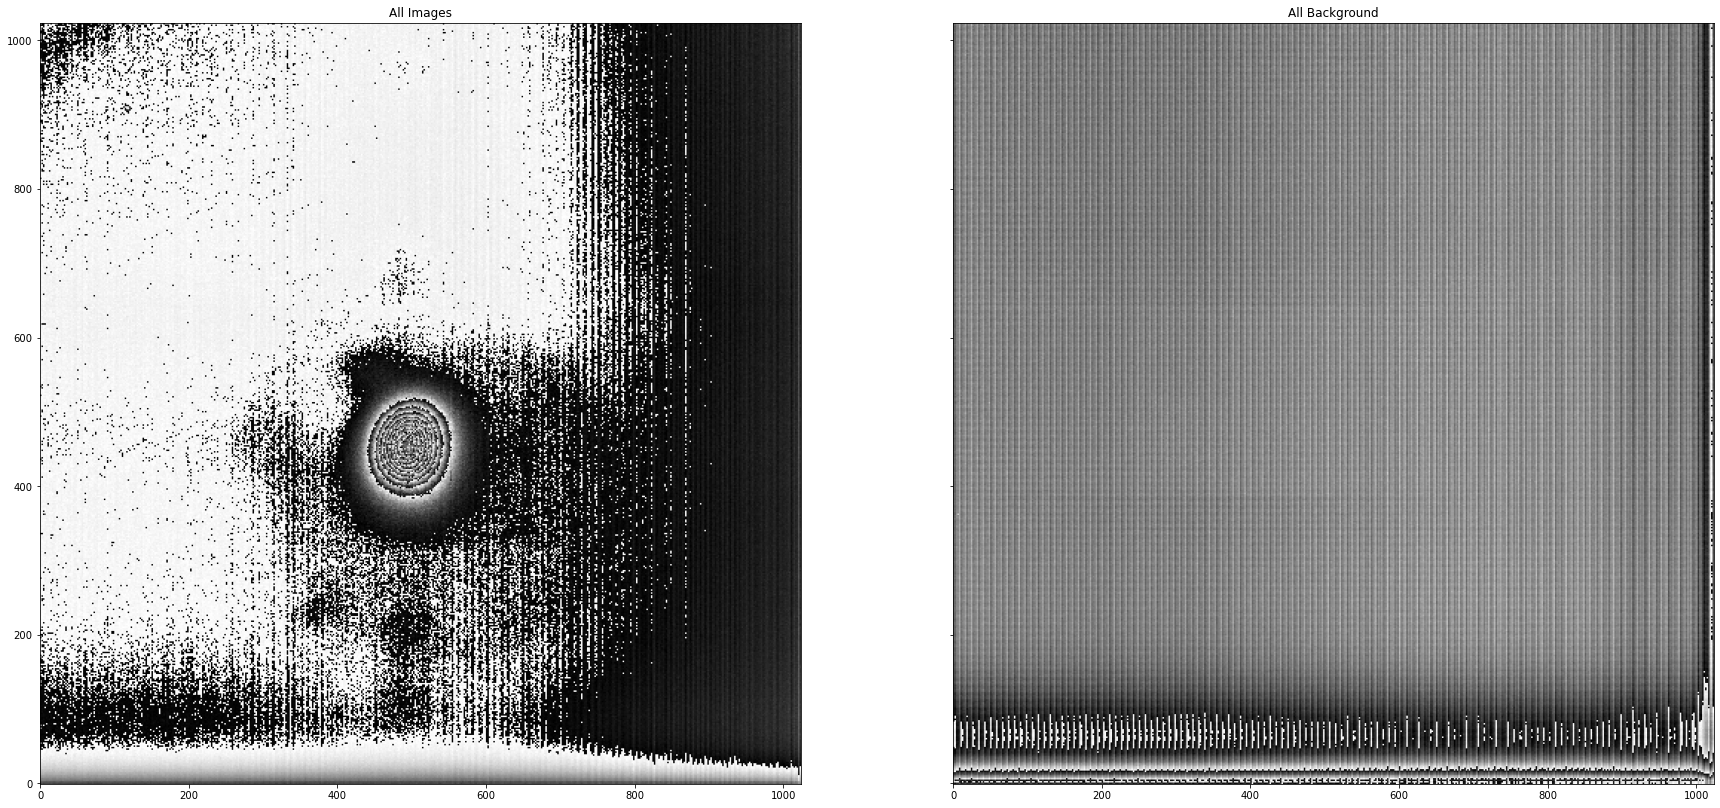

In [9]:
pws2=getPowerSpectrum(ELDay2Images,BackGroundDay2,"WienerDay22_test")

Minimum kval = 1.0 and Maximum kval= 512.0


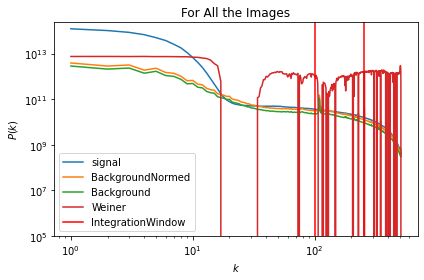

In [10]:
Wiener1d=PpectrumNormed(pws2[2],pws2[1],"For All the Images","WienerDay22_test.p")

[[1.29836303 1.33822583 1.34559212 ... 1.19892941 1.05224765 0.91949956]
 [1.33822583 1.37693508 1.38409536 ... 1.24198775 1.1010572  0.97497757]
 [1.34559212 1.38409536 1.3912188  ... 1.24992133 1.10999852 0.98506397]
 ...
 [1.19892941 1.24198775 1.24992133 ... 1.09046638 0.92677414 0.77276427]
 [1.05224765 1.1010572  1.10999852 ... 0.92677414 0.72712013 0.51667979]
 [0.91949956 0.97497757 0.98506397 ... 0.77276427 0.51667979 0.07219641]]
3716.3544444427503
4006.868955042495


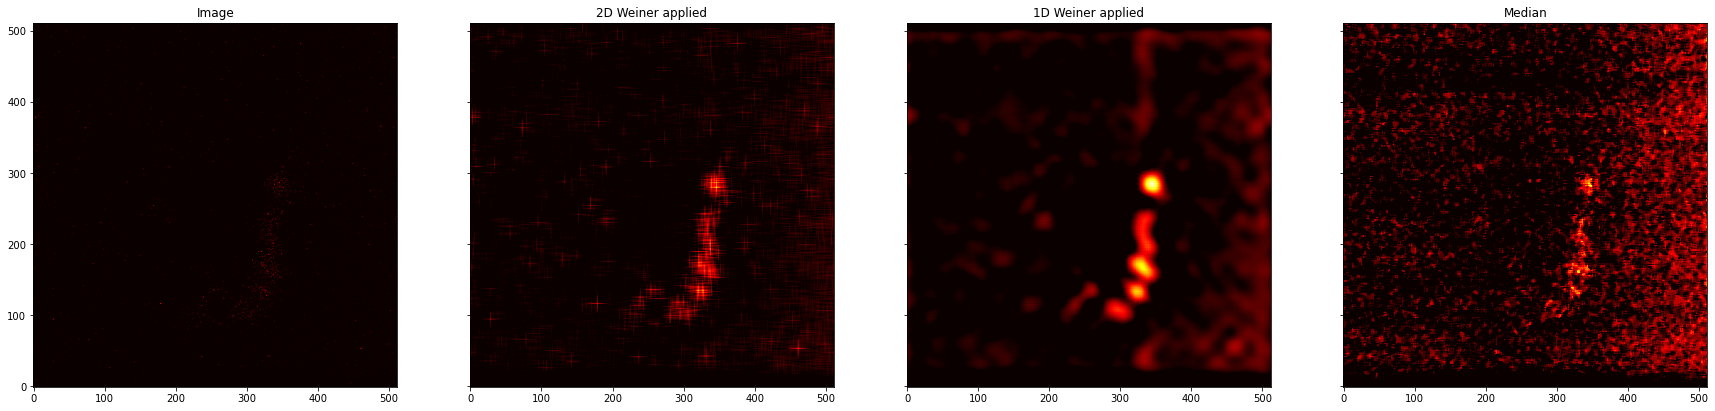

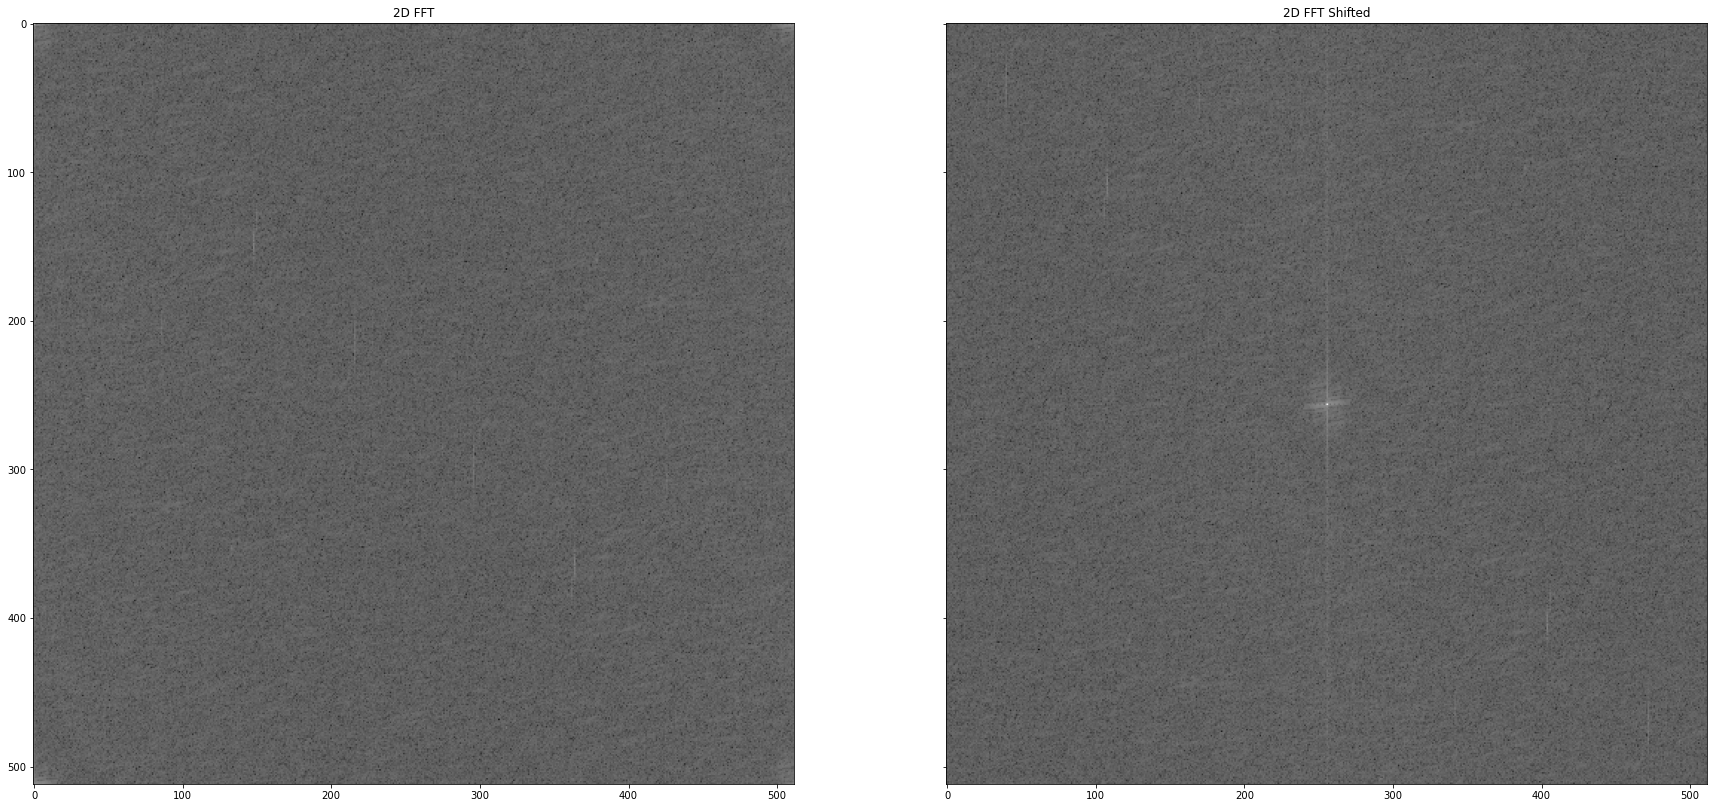

In [11]:

#### Single Image Recovery
SingleImg=ELDay2ImagesTest[935]
fft_SingleImg=np.fft.fft2(SingleImg)
PS_SingleImg=(np.abs(fft_SingleImg))**2

## 2D wiener
restored = np.fft.ifft2(fft_SingleImg*(kk[0]+kk[1]))
restored = np.real(restored)

print(r)
## 1D Wiener
test=scipy.ndimage.median_filter(SingleImg,size=6)

#unshifted=fft_SingleImg*kk[0]*kk[1]
unshifted=fft_SingleImg*kk[0]*kk[1]
restored2 = np.fft.ifft2(unshifted)

restored2 = np.real(restored2)

# take real() component (or do abs())

print(np.amin(restored))
print(np.amax(restored))
# clip and convert to uint8
#SingleImg=np.real(SingleImg).clip(0,255).astype(np.uint8)
#restored2 = restored2.clip(0,255).astype(np.uint8)
#restored = restored.clip(0,255).astype(np.uint8)
#restored3 = restored3.clip(0,255).astype(np.uint8)
#test = test.clip(0,255).astype(np.uint8)

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(30, 20), sharex=True, sharey=True)
ax[0].set_title('Image')
ax[0].imshow(SingleImg,cmap=plt.get_cmap('hot'),origin="lower",vmin=(np.mean(SingleImg)), vmax=np.max(SingleImg))
ax[1].set_title('2D Weiner applied')
ax[1].imshow(restored,cmap=plt.get_cmap('hot'),origin="lower",vmin=(np.mean(restored)), vmax=np.max(restored))
ax[2].set_title('1D Weiner applied')
ax[2].imshow(restored2,cmap=plt.get_cmap('hot'),origin="lower",vmin=(np.mean(restored2)), vmax=np.max(restored2))
ax[3].set_title('Median')
ax[3].imshow(test,cmap=plt.get_cmap('hot'),origin="lower", interpolation='nearest',vmin=(np.mean(test)), vmax=np.max(test))

#restore5 = restore5.clip(0,255).astype(np.uint8)

#ax[1].imshow(20*np.log10(abs(fft_SingleImg)*),cmap='gray')
plt.show()
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(30, 20), sharex=True, sharey=True)
ax[0].set_title('2D FFT')
ax[0].imshow(10*np.log10(np.abs(fft_SingleImg)),cmap='gray')
ax[1].set_title('2D FFT Shifted')
ax[1].imshow(10*np.log10(np.abs(np.fft.fftshift(fft_SingleImg))),cmap='gray')
#ax[1].set_title('2D Weiner applied')
#ax[1].imshow(10*np.log10(np.abs(np.fft.fft(restored))),cmap='gray')
#ax[2].set_title('1D Weiner applied')
#ax[2].imshow(10*np.log10(np.abs(np.fft.fft(restored2))),cmap='gray')


